# Train a U-Net for Cell Segmentation

To segment the full cell, including the cytosol, we first train a U-Net to predict the foreground (whether a pixel belongs to a cell or not) and boundaries of the cells.
We will later uses these predictions to segment the cells using a seeded watershed from the nucleus predictions (see previous notebooks).

In this notebook we will use PyTorch to train the U-Net based on the serum channel of the images and the cell segmentation ground-truth. The goal of this lesson is to learn how to train a U-Net for segmentation tasks.

Note that U-Nets can also be used for other tasks where the input image should be transformed into another kind of image, for example denoising.

We recommend to first finish the exercises `cell_classification/pytorch/train_infection_classifier` and `nucleus_segmentation/bioimageio/pretrained_segmentation` before working on this exercise.

In [ ]:
# General imports.

import os
import sys
from glob import glob
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import napari
import numpy as np

sys.path.append("../..")
import utils

In [ ]:
# This function will download and unpack the data and do some further data preparation.
# It will only be executed if the data has not been downloaded yet.
data_dir = "../../data"
if os.path.exists(data_dir):
    print("The data is downloaded already.")
else:
    utils.prepare_data(data_dir)

### 1. Prepare the data for training

As the first step we extract the data for training, validation and test. Here, we load the serum channel (as input image to the model) and the cell segmentation (as annotations for training). The functions here are similar to the cell classification exercise, but the data extraction is easie because we do not cut out small patches acrosss individual cells, but instead just load the whole image. (Further data processing will happen later in the `pytorch dataset`.)

In [ ]:
# The data has been downloaded and separated into folders for the train, validation and test split already.
# We first create a dictionary with the location of the three different split folders.
data_dirs = {
    "train": os.path.join(data_dir, "train"),
    "val": os.path.join(data_dir, "val"),
    "test": os.path.join(data_dir, "test")
}

# And check the content for one of the samples.
# After the print you should see the images (marker, nuclei, serum), labels (cells and nuclei) as well as a json file.
train_sample0 = os.path.join(data_dirs["train"], "gt_image_000")
print(os.listdir(train_sample0))

In [ ]:
# We first define the functions to load and process the training and validation data.

# This is a helper function for normalizing an image to the range [0, 1].
# Data normalization is important when training neural networks for image data
# to make sure all the inputs are in the same data range.
def normalize(image):
    image = image.astype("float32")
    # Normalise the image to roughly [0,1]
    image = image - image.min()
    # We don't use the max value here, because there are a few very bright
    # pixels in some images, that would otherwise throw off the normalization.
    # Instead we use the 95th percentile to be robust against these intensity outliers.
    max_value = np.percentile(image, 95)
    image /= max_value
    return image


# This function extracts the image data (serum channel) and the corresponding cell segmentation.
def extract_images_and_labels(sample_folder):

    # Get the filepath for the tifs containing image and segmentation. 
    sample_name = os.path.basename(sample_folder)
    serum_path = os.path.join(sample_folder, f"{sample_name}_serum_image.tif")
    cell_segmentation_path = os.path.join(sample_folder, f"{sample_name}_cell_labels.tif")

    # Load and normalize the image data, load the cell segmentation data.
    serum = normalize(imageio.imread(serum_path))
    cells = imageio.imread(cell_segmentation_path)

    return serum, cells

In [ ]:
# This function applies the data extraction for a given split (train, validation or test)
def prepare_split(split):
    split_folder = data_dirs[split]
    samples = glob(os.path.join(split_folder, "gt*"))
    images, labels = [], []
    for sample in samples:
        sample_image, sample_labels = extract_images_and_labels(sample)
        images.append(sample_image)
        labels.append(sample_labels)
    return images, labels

In [ ]:
# Now we apply the functions for the training, validation and test split
# and check how many samples we have for each split.

train_images, train_labels = prepare_split("train")
print("We have", len(train_images), "training samples.")

In [ ]:
val_images, val_labels = prepare_split("val")
print("We have", len(val_images), "validation samples")

In [ ]:
test_images, test_labels = prepare_split("test")
print("We have", len(test_images), "test samples")

In [ ]:
viewer = napari.Viewer()
# Visualize the image data and labels.
viewer.add_image(train_images[0], colormap="green")
viewer.add_labels(train_labels[0])

You should see that the data looks somewhat like this (after changing the contrast limits and switching the segmentation display to outlines):

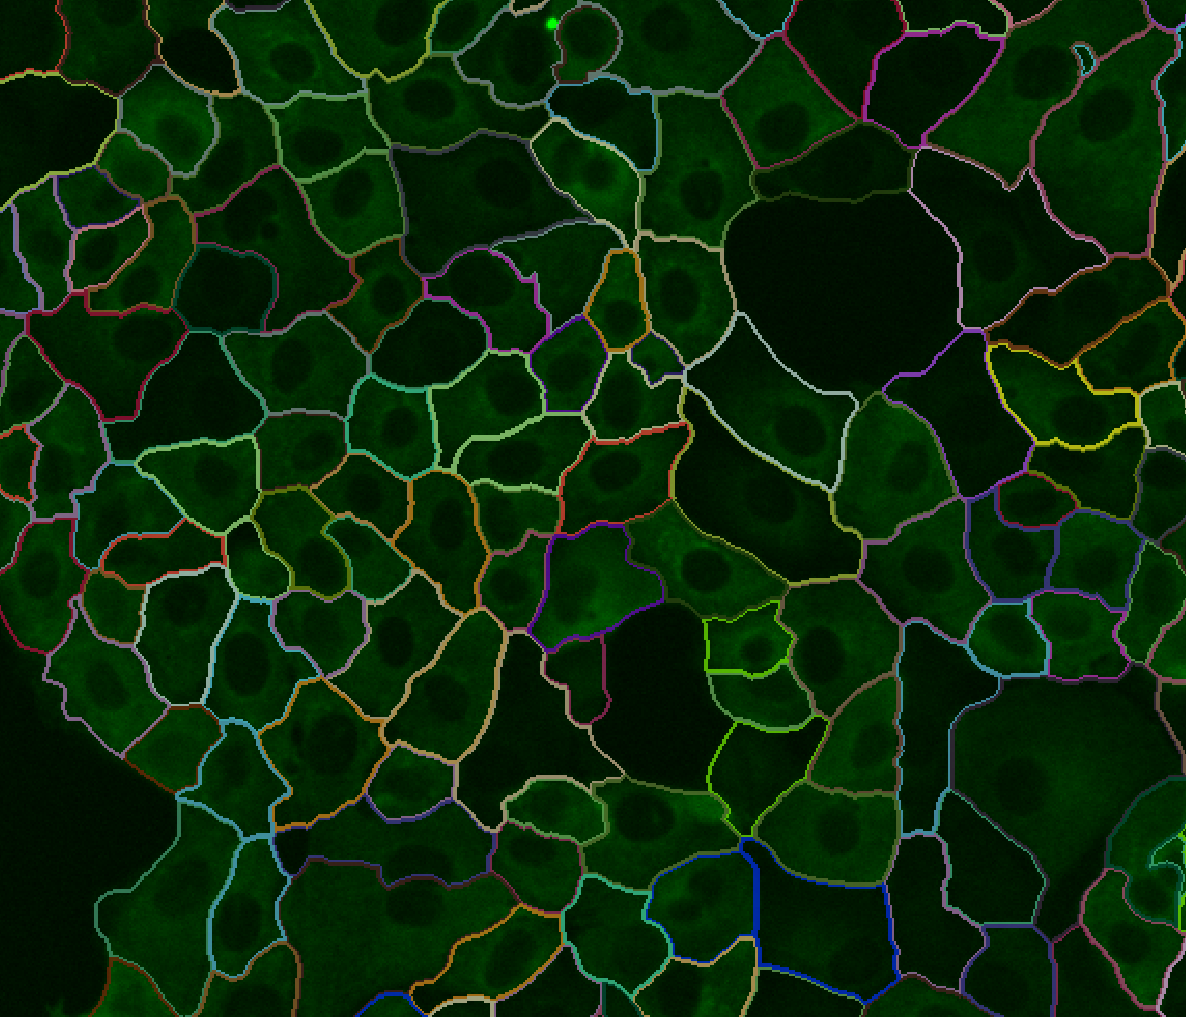

### 2. Create dataset and dataloader

As the next step we define the `Dataset` and `DataLoader`.

Creating the `Dataset` and `DataLoader` will be similar to the cell classification exercise, but the processing steps in the `Dataset` to extract image patches and annotations for training will be different.

The biggest difference will be that the annotations will now contain values per pixel, so they will be like an image, rather than just being a single class per image. 

In [ ]:
# Import the PyTorch functionality we need.
import torch
from torch.utils.data import Dataset, DataLoader

import tqdm
import torch.nn as nn
import torch.nn.functional as F

# Additional imports for image transformations.
from torchvision.transforms import v2
from skimage.segmentation import find_boundaries

In [ ]:
# We first check if we have access to a GPU.
# The model training will be much faster if we can use a GPU.
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is NOT available. The training will be very slow!")
    device = torch.device("cpu")

In [ ]:
# Build a dataset for returing images and labels for training the segmentation network.
class CustomDataset(Dataset):
    # Here we pass the parameters for creating the dataset:
    # The image data, the labels and the patch shape (= the size of the image patches used for training).
    # mask_transform is a function that is applied only to the label data, in order to convert the cell segmentation
    # we have as labels, which cannot be used for directly training the network, into a different representation
    # transform is an additonal argument that can be used for defining data augmentations (optional exercise)
    def __init__(self, images, labels, patch_shape, mask_transform, transform=None):
        self.images = images
        self.labels = labels
        self.patch_shape = patch_shape
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images)

    # The __getitem__ method returns the image data and labels for a given sample index.
    def __getitem__(self, index):

        # get the current image and mask (= cell segmentation)
        image = self.images[index]
        mask = self.labels[index]
        assert image.ndim == mask.ndim == 2
        assert image.shape == mask.shape

        # Extract the patches for training from the image and label data
        # Random crop same excerpt from image and mask
        i, j, h, w = v2.RandomCrop.get_params(
            torch.tensor(image), output_size=self.patch_shape
        )
        image = v2.functional.crop(torch.tensor(image), i, j, h, w)
        mask = v2.functional.crop(torch.tensor(mask), i, j, h, w)
        
        # make sure to add the channel dimension to the image
        image, mask = np.array(image), np.array(mask)
        if image.ndim == 2:
            image = image[None]      
        
        # Apply transform if it is present.
        if self.transform:
            image, mask = self.transform(image, mask)         

        # Apply specific transform for the mask.
        mask = self.mask_transform(mask)   

        return image, mask

In [ ]:
def label_transform(mask):
    mask = np.array(mask)
    fg_target = (mask > 0).astype("float32")
    bd_target = find_boundaries(mask, mode="thick").astype("float32")
    return np.stack([fg_target, bd_target])

In [ ]:
patch_shape = (512, 512) 
batch_size = 1

# create datasets
train_dataset = CustomDataset(train_images, train_labels, patch_shape=patch_shape, mask_transform=label_transform)
val_dataset = CustomDataset(val_images, val_labels, patch_shape=patch_shape, mask_transform=label_transform)
test_dataset = CustomDataset(test_images, test_labels, patch_shape=patch_shape, mask_transform=label_transform)

# create loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
im, target = next(iter(train_dataset))
viewer = napari.Viewer()
viewer.add_image(im)
viewer.add_image(target)
napari.run()

You should see the image channel (in grayscale) and the two target channels, the first containing the foreground vs. background annotations and the second containing the boundary annotations. The annotations should match the image data, as in the example below.
(With some tricks to view things side by side in napari, you don't need to do that but can instead check the data interactively.)

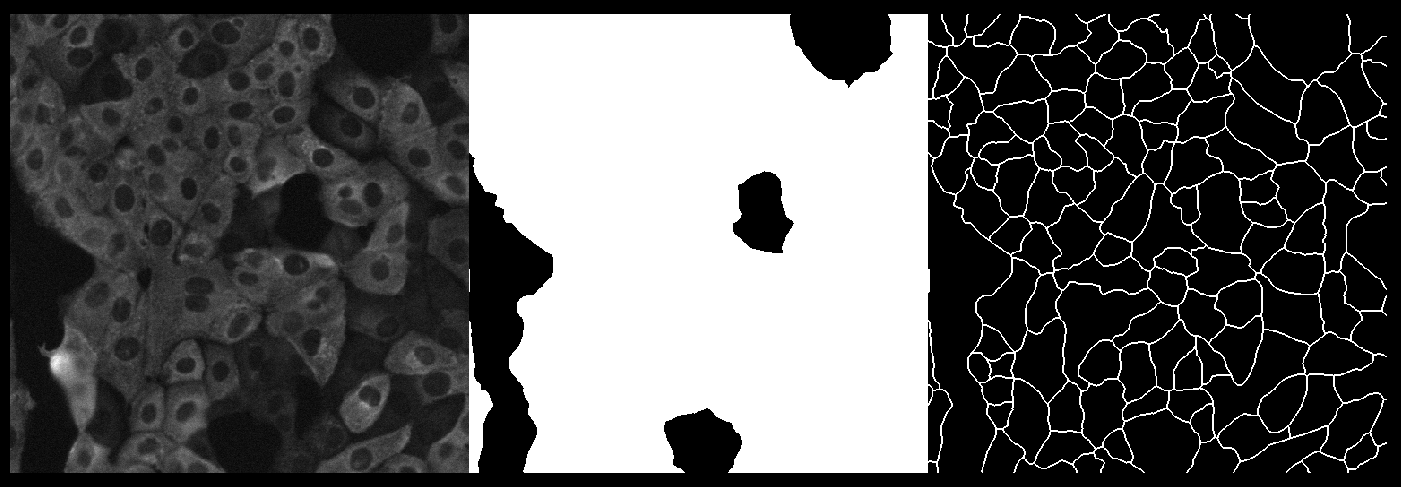

### 3. Implement and check U-Net

Now we implement the U-Net architecture. The U-Net is a very versatile network that can be used for image segmentation, but also for other tasks where we "translate" an image into some other representation, for example for denoising images. We will follow the implementation as described in [the original publication](https://arxiv.org/abs/1505.04597). See the implementation overview:

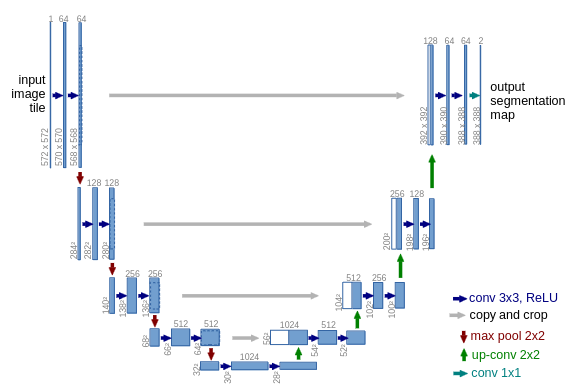

We will make three different design choice compared to the architecture above:
- Use convolutions with padding. This means that the prediction of the U-Net will have the same image shape as the input. This change makes it much easier to use the network. (It can lead to some artifacts, but they can be avoided by cropping the border of the prediction later).
- Make the number of parameters configurable and use a smaller architecture that starts with 32 channels in the first level by default. So in comparison to the figure the number of channels in the U-Net will be smaller by a factor of 2 throughout.  
- Use a normalization layer in the convolutional block. Normalization layers make sure that the outputs of all intermediate layers stay in a good data range and make training networks more stable.

In [ ]:
# We implement the U-Net as a class that inherits from nn.Module.
# This is how custom neural networks are implemented in PyTorch.
class UNet(nn.Module):

    # This function creates a convolutional block with the given number of input and output features.
    # Here, the number of features means the number of channels predicted by a convolutional layer.
    # Each block contains two convolutional layer with a kernel size of 3.
    # We use Instance Normalization to keep the layer output activations in a good data range
    # and use the ReLU activation function.
    def conv_block(self, in_feats, out_feats):
        return nn.Sequential(
            nn.InstanceNorm2d(in_feats),
            nn.Conv2d(in_feats, out_feats, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.InstanceNorm2d(out_feats),
            nn.Conv2d(out_feats, out_feats, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    # The init function defines the parameters that can be given to the U-Net.
    # Here, we need to pass out_channels, which defines the number of output channels in the image predicted by the image.
    # initial_features sets the number of output features in the first level and thus controls the overall number of parameters of the U-Net
    def __init__(self, out_channels, initial_features=32, in_channels=1, sigmoid_activation=True):
        super().__init__()  # This initializes the pytorch module.

        # Define the number of channels ("features") throughout the U-Net. We increase the number of channels by a factor of 2
        # in each encoder level of the U-Net.
        # The first list defines the input channels of each level and the second the output channels.
        in_features = [in_channels, initial_features, initial_features * 2, initial_features * 4]
        out_features = [initial_features, initial_features * 2, initial_features * 4, initial_features * 8]

        # Build the encoder (= the lefthand side of the U-Net). Each encoder is a convolutional block.
        self.encoders = nn.ModuleList([
            self.conv_block(in_feats, out_feats) for in_feats, out_feats in zip(in_features, out_features)
        ])
        # Build the max-pooling layers that downsample the image representation after each encoder block.
        self.poolers = [nn.MaxPool2d(2)] * len(in_features)
        # Build the base block (= the conv block that is applied at the bottom of the U-Net, after the encoders).
        self.base = self.conv_block(initial_features * 8, initial_features * 16)

        # Define the number of channels for the decoders of the U-Net. The decoder corresponds to the right-hand path
        # of the U-Net, where the image representation is up-sampled again and combined with the representation from the
        # corresponding encoder level through the skip connections.
        in_features = [initial_features * 16, initial_features * 8, initial_features * 4, initial_features * 2]
        out_features = [initial_features * 8, initial_features * 4, initial_features * 2, initial_features]
        # Build the encoder blocks.
        self.decoders = nn.ModuleList([
            self.conv_block(in_feats, out_feats)
            for in_feats, out_feats in zip(in_features, out_features)
        ])
        # Build the upsampling layers that increase the spatial shape of the  image representation
        # after each decoder layer. We use a transposed convolutional layer for upsampling.
        self.upsamplers = nn.ModuleList([
            nn.ConvTranspose2d(in_feats, out_feats, 2, stride=2)
            for in_feats, out_feats in zip(in_features, out_features)
        ])

        # Build the last convolutional layer that maps the predicted image to the desired number of output channels.
        # We make use of a 1x1 convolution here.
        self.out_conv = nn.Conv2d(out_features[-1], out_channels, kernel_size=1)
        
        # Add the sigmoid activation if specified.
        # (This can be deactivated for loss functions that expect a different output range than [0, 1])
        self.sigmoid_activation = sigmoid_activation
        if sigmoid_activation == True:
            self.last_activation = nn.Sigmoid()

    # The "forward" function defines how the data flows through the network.
    def forward(self, x):
        # We first pass the input data through the encoder (left path) of the U-Net. After each
        # encoder block we save the representation in the 'from_encoder' list, so that we can later
        # pass it to the corresponding decoder (these are the skip connections!) and then downsample the representation.
        from_encoder = []
        for encoder, pooler in zip(self.encoders, self.poolers):
            x = encoder(x)
            from_encoder.append(x)
            x = pooler(x)

        # Apply the base layer.
        x = self.base(x)

        # Then go through the decoder (right path of the U-Net).
        # Before the data goes into encoder we upsample it and concatenate the corresponding encoder representation,
        # which we saved in the 'from_encoder' list before.
        from_encoder = from_encoder[::-1]  # reverse the list so that it matches going from down to up.
        for decoder, upsampler, from_enc in zip(self.decoders, self.upsamplers, from_encoder):
            x = decoder(torch.cat([
                from_enc, upsampler(x)
            ], dim=1))

        # Apply the last convolution to map to the correct number of output channels.
        x = self.out_conv(x)
        # And apply the sigmoid activation if specified.
        if self.sigmoid_activation:
            x = self.last_activation(x)

        return x

In [ ]:
# Now let's initiate a U-Net with a single output channel to check that everything works correctly.
model = UNet(out_channels=1)

In [ ]:
# Let's apply it to one image to check that prediction also works.
with torch.no_grad():
    im, _ = next(iter(train_loader))
    prediction = model(im)

# We have not trained the U-net at all yet, so all the weights in the network are just randomly initialized.
# How do you expect the output to look?

In [ ]:
# Let's check it visually in napari!
viewer = napari.Viewer()
viewer.add_image(im.cpu().numpy(), name="image")
viewer.add_image(prediction.cpu().numpy(), name="prediction")

### 4. Train the UNet to predict foreground and boundaries

Now that we have the dataloaders and the model implementation we can go over to the actual training. We implement the training and validation functions below. These are quite similar to the implementations for the cell classification task.

In [ ]:
# This is the function to train the model for one epoch.
def train_epoch(model, loader, loss, metric, optimizer):
    model.train()
    metric_list, loss_list = [], []
    for i, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss_value = loss(pred, y)
        loss_value.backward()
        optimizer.step()
        loss_list.append(loss_value.item())
        if metric is not None:
            metric_value = metric(pred, y)
            metric_list.append(metric_value.item())

    if metric is not None:
        return np.mean(loss_list), np.mean(metric_list)
    else:
        return np.mean(loss_list), None

In [ ]:
# This function validates the model after the epoch.
def validate(model, loader, loss, metric):
    model.eval()
    metric_list, loss_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss_value = loss(pred, y).item()
            loss_list.append(loss_value)
            if metric is not None:
                metric_value = metric(pred, y).item()
                metric_list.append(metric_value)

    if metric is not None:
        return np.mean(loss_list), np.mean(metric_list)
    else:
        return np.mean(loss_list), None

In [ ]:
# And this defines the complete training.
def run_training(
    model, train_loader, val_loader, loss, metric, optimizer, n_epochs
):
    train_losses, train_metrics = [], []
    val_losses, val_metrics = [], []
    for epoch in tqdm.trange(n_epochs):
        train_loss, train_metric = train_epoch(model, train_loader, loss, metric, optimizer)
        val_loss, val_metric = validate(model, val_loader, loss, metric)
        
        # save the loss and accuracy for plotting
        train_losses.append(train_loss)
        train_metrics.append(train_metric)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
    
    return train_losses, train_metrics, val_losses, val_metrics

In [ ]:
# This function plots the training progress.
def plot_training(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()


    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        plt.plot(*extra_pt, 'ok')
    if extra_pt_label:
        legend.append(extra_pt_label)
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

We use the [Dice Score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) as loss function in this exercise. The dice score measures the intersection over union between two segmentations (i.e. how well they match). It is commonly used to evaluate how well two binary segmentations fit to each other. It takes values between 0 (no match at all) and 1 (perfect match). It can also be used as a loss function. It is not as sensitive to unbalanced data as the cross entropy loss. We have quite unbalanced data, in particular the boundary target channel, that is why we use it here..

In [ ]:
# Define a loss function based on the dice score.
class DiceLoss(nn.Module):
    def forward(self, input_, target):
        # We have already implemented the dice score in the utils.py file.
        # In order to use it as a loss we have to take 1 - dice.
        # Because a high dice score corresponds to a good result, but we minimize the loss,
        # so a low value for the loss must correspond to a good result.
        return 1. - utils.dice_score(input_, target)

In [ ]:
# Now we instantiate the U-Net for our task, with two output channels, and the loss function.
model = UNet(initial_features=32, out_channels=2, sigmoid_activation=True)
model.to(device)
loss = DiceLoss()
loss.to(device)

In [ ]:
# run the training again
n_epochs = 20

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=batch_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # default LR -3
metric = utils.dice_score
train_losses, train_scores, val_losses, val_scores = run_training(model, train_loader, val_loader, loss, metric, optimizer, n_epochs)
plot_training('Loss vs. Epoch', 'Loss', train_losses, val_losses)
plot_training('Dice Score vs. Epoch', 'Dice Score', train_scores, val_scores)

In [ ]:
# Let's check the segmentation predictions for a few test images.
counter = 0
with torch.no_grad():
    for im, mask in test_loader:
        if counter >= 3:
            break
        pred = model(im.to(device))
        pred = torch.tensor(pred).cpu().numpy().squeeze()
        viewer = napari.Viewer()
        viewer.add_image(im.numpy(), name="Input")
        viewer.add_image(mask.numpy().squeeze()[0], name="Target Foreground")
        viewer.add_image(pred[0], name="Prediction Foreground")
        viewer.add_image(mask.numpy().squeeze()[1], name="Target Boundaries")
        viewer.add_image(pred[1], name="Prediction Boundaries")
        napari.run()
        counter += 1

### 5. Save and Load Models
Now let's look at how to save a trained model and how to load it with `state_dict` from [torch](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

In [ ]:
# define a path and create a folder to save the model
save_folder = os.path.join(data_dir, "models", "state_dicts")
os.makedirs(save_folder, exist_ok=True)
model_name = "UNet_cell_membrane_state_dict"
model_path = os.path.join(save_folder, model_name)

In [ ]:
# save the models state_dict
torch.save(model.state_dict(), model_path)

In [ ]:
# create a new model and check that it's not trained
model = UNet(initial_features=32, out_channels=2, sigmoid_activation=True)
model.to(device)
loss = DiceLoss()
loss.to(device)

In [ ]:
# Let's apply it to one image to check that prediction also works.
with torch.no_grad():
    im, _ = next(iter(train_loader))
    prediction = model(im.to(device))

In [ ]:
# Let's check it visually in napari!
viewer = napari.Viewer()
viewer.add_image(im.cpu().numpy(), name="image")
viewer.add_image(prediction.cpu().numpy(), name="prediction")

In [ ]:
# load the models state_dict
model.load_state_dict(torch.load(save_folder+model_name))
model.eval()

In [ ]:
# Let's apply it again to one image to check that prediction also works.
with torch.no_grad():
    im, _ = next(iter(train_loader))
    prediction = model(im.to(device))

In [ ]:
# Let's check it visually in napari!
viewer = napari.Viewer()
viewer.add_image(im.cpu().numpy(), name="image")
viewer.add_image(prediction.cpu().numpy(), name="prediction")

### 6. Run prediction

We now apply the model to all test image and save the predictions for foreground and boundaries as tif images.

In [ ]:
# We create a folder where we can save the cell membrane predictions.
output_folder = os.path.join(data_dir, "predictions", "cell-membranes")
os.makedirs(output_folder, exist_ok=True)

In [ ]:
# padding functions to fit images to desired shape
def pad_tensor(input_tensor, target_shape):
    batch_size, channels, height, width = input_tensor.shape
    pad_height = target_shape[2] - height
    pad_width = target_shape[3] - width

    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top

    padded_tensor = F.pad(input_tensor, (pad_left, pad_right, pad_top, pad_bottom))
    return padded_tensor, (pad_top, pad_bottom, pad_left, pad_right)  # Return padding information

def unpad_tensor(padded_tensor, padding_info):
    pad_top, pad_bottom, pad_left, pad_right = padding_info
    unpadded_tensor = padded_tensor[:, :, pad_top:padded_tensor.shape[2]-pad_bottom, pad_left:padded_tensor.shape[3]-pad_right]
    return unpadded_tensor

In [ ]:
# This function runs prediction for an image.
def run_prediction(model, image, target_shape=(1, 1, 1024, 1024), device=device):
    # Bring the input into the correct format and type.
    input_ = image[None, None] # add batch and channel dimensions
    input_ = torch.tensor(input_) # to tensor
    
    # Apply the model. Here, we use prediction with padding to deal with images
    # that have a shape that is not compatible with the model.
    # Predict with padding if the image is not in correct shape
    # to be processed by the network. 
    # Afterwards remove padding from prediction
    if input_.shape != target_shape:
        input_, padding_info = pad_tensor(input_, target_shape)
        pred = model(input_.to(device))
        pred = pred.detach().cpu()
        pred = unpad_tensor(pred, padding_info)
        prediction = pred.numpy().squeeze()
    else:
        prediction = model(input_.to(device))
        prediction = prediction.cpu().numpy().squeeze()

    # Apply the pos-processing to get a segmentation mask.
    foreground, boundaries = prediction[0], prediction[1]
    
    return foreground, boundaries

In [ ]:
# Get all the images for the serum channel in the test images.
input_files = glob(os.path.join(data_dir, "test", "gt_*", "*_serum_image.tif"))

In [ ]:
# Run prediction for all the test images.
# We add a progress bar to know how long it will take.

target_shape=(batch_size, 1, 1024, 1024)
with torch.no_grad():
    for path in tqdm.tqdm(input_files):
        image = imageio.imread(path)
        foreground, boundaries = run_prediction(model, image, target_shape=target_shape)
    
        # We save the segmentation as a compressed tif, using a filename that matches the input name.
        filename = os.path.basename(path)
        output_path_foreground = os.path.join(output_folder, "foreground_"+filename)
        output_path_boundaries = os.path.join(output_folder, "boundaries_"+filename)
        imageio.imwrite(output_path_foreground, foreground, compression="zlib")
        imageio.imwrite(output_path_boundaries, boundaries, compression="zlib")

In [ ]:
# Let's make sure that the predictions were saved correctly for the last image.
viewer = napari.Viewer()
viewer.add_image(imageio.imread(output_path_foreground))
viewer.add_image(imageio.imread(output_path_boundaries))
napari.run()

## Exercises

Implement instance segmentation for the cells. Use the nucleus segmentation from the previous exercise and the foreground boundary predictions from this exercise to segment the individual cells.

Use a [watershed](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.watershed) for this, by:
- Using the boundary predictions as input / height map for the watershed.
- Using the nucleus segmentation as markers / seeds.
- And using the foreground prediction to compute a mask.

The idea behind this approach is the following: each cell contains a nucleus, and we already have a good nucleus segmentation from the previous exercise. So we expand this segmentation to the full cel, by using the nuclei as markers in the watershed. The boundary predictions serve to separate cells at the correct location (i.e. where their cell membranes touch) and the masks derived from the foreground prediction ensures that the segmentation does not spill into the background (i.e. areas where there are no cells).

Implement this procedure for one image and make sure that it works (visually). Then apply it to all test images and evaluate the segmentation quality using the same approach as in `nucleus_segmentation/bioimageio/pretrained_segmentation`.

## Advanced Exercises

- Train with a larger U-Net (a U-net with more parameters, which you can control by the initial features). What do you observe? Does this change the quality of predictions visually? Does it make a difference in the evaluation of the instance segmentation (i.e. after watershed from the nuclei)?
- Implement data augmentation to extend the effective size of the training data set. You can use [torchvision.transform](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html) to implement the data augmentations. The `transform` argument of the `CustomDataset` can be used to apply these augmentations during training.
    - You can use augmentations that are only applied to the image data, like noise.
    - Or augmentations that apply to both image data and labels, like image flips or rotations. For these cases you have to make sure that the same augmentation is applied to image and label!
    - Make sure to randomize whether augmentations are applied.
- Try out training with different loss functions.
    - You can either try training with a Cross Entropy Loss (in this case you need to adapt the labels so that foreground and boundary labels are mutually exclusinve) or with a Binary Cross Entropy Loss that is applied independently per channel (in this case you can use the same labels as before).
    - If you use a loss functions that needs outputs without activation then set `sigmoid_activation=False` in the U-Net.
    - You should experiment with weighting the loss function to counteract the class imbalance.  